| Name                 | ID       |
|----------------------|----------|
| Jaime Simoes         | 20230522 |
| Maximilian Laechelin | 20230979 |
| Ilyass Jannah        | 20230598 |


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from dateutil import parser
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from minisom import MiniSom
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors as mpl_colors, colorbar
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth, AgglomerativeClustering
from sklearn.base import clone
from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage

sns.set()

In [2]:
data = pd.read_csv('XYZ_sports_dataset.csv', sep=";", index_col="ID")

In [3]:
data.index = data.index - 10000

In [4]:
data.head()

,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,LifetimeValue,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
ID,,,,,,,,,,,,,,,,,,,,,
0,60,Female,5500.0,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,1,89.35,...,0.0,9.0,7,NaN,6.28,2,0,0.0,0,0
1,29,Female,2630.0,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,60,479.20,...,0.0,23.0,1,2.0,17.42,1,2,0.0,0,1
2,23,Male,1980.0,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,7,37.60,...,0.0,6.0,0,7.0,30.03,6,0,0.0,0,1
3,9,Male,0.0,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,22,155.40,...,0.0,20.0,2,2.0,17.72,3,0,0.0,0,1
4,35,Male,4320.0,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,210,373.20,...,NaN,41.0,0,7.0,60.97,0,3,0.0,0,1


In [5]:
# Calculate the percentage of NaN values per column and order them in descending order
nan_percentage = data.isna().sum() / len(data) * 100
nan_percentage = nan_percentage.sort_values(ascending=False)

# Create a table displaying the percentage of NaNs per column
nan_table = pd.DataFrame(nan_percentage, columns=['% of NaNs']).reset_index()
nan_table.rename(columns={'index': 'Column'}, inplace=True)

# Display the table
nan_table

,Column,% of NaNs
0,AllowedWeeklyVisitsBySLA,3.580511
1,Income,3.312810
2,NatureActivities,0.314550
3,SpecialActivities,0.294472
4,RacketActivities,0.247624
5,WaterActivities,0.247624
6,AthleticsActivities,0.240932
7,DanceActivities,0.240932
8,OtherActivities,0.234239
9,FitnessActivities,0.234239


# PreProcessing

## Dropout

In [6]:
# this feature introcudes two main categories which we will have to keep an eye throughout the analysis
# an interesting approach would be the predictions of this feature based on the other features which would give a valueable insight for the company but we will not do that here

In [7]:
# value counts of dropout
data['Dropout'].value_counts()

Dropout
1    11968
0     2974
Name: count, dtype: int64

## EnrollmentStartFinish

In [8]:
data['EnrollmentStart'] = pd.to_datetime(data['EnrollmentStart'])
data['EnrollmentFinish'] = pd.to_datetime(data['EnrollmentFinish'])

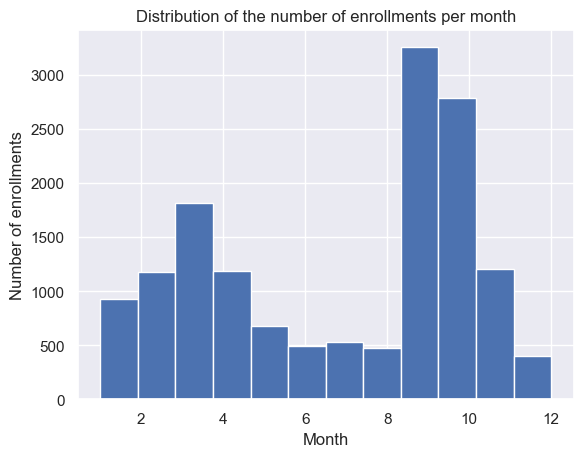

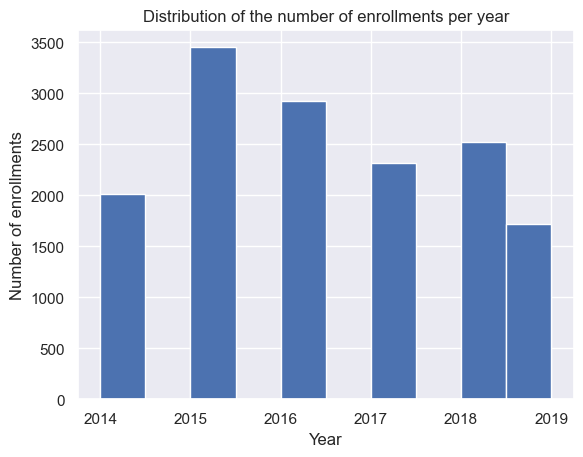

In [9]:
data['EnrollmentStart'].dt.month.hist(bins=12)
plt.xlabel('Month')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollments per month')
plt.show()

# per year
data['EnrollmentStart'].dt.year.hist(bins=10)
plt.xlabel('Year')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollments per year')
plt.show()

In [10]:
# enrollments are kinda decreasing over the years and way more enrollments in september and october

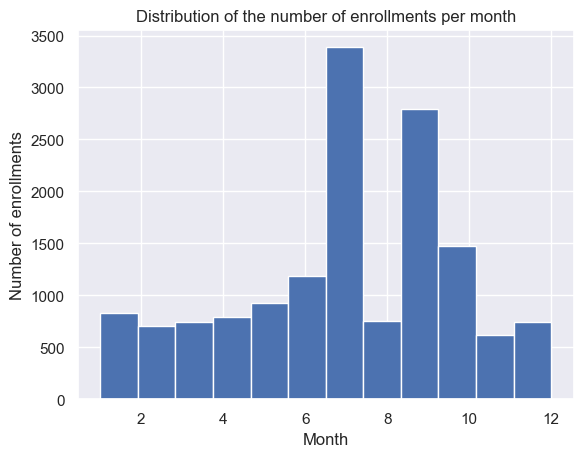

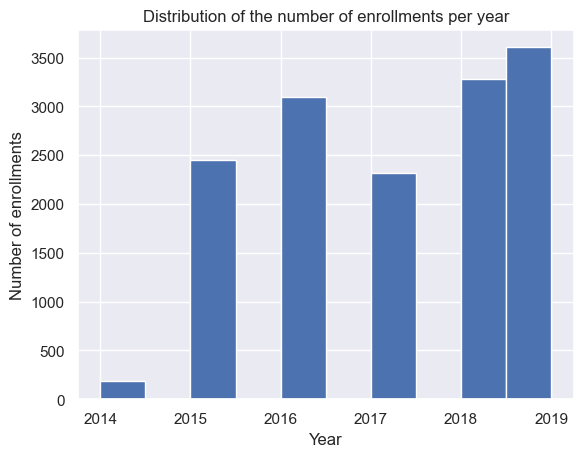

In [11]:
# distribution of EnrollmentFinish per month
data['EnrollmentFinish'].dt.month.hist(bins=12)
plt.xlabel('Month')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollments per month')
plt.show()

# distribution of EnrollmentFinish per year
data['EnrollmentFinish'].dt.year.hist(bins=10)
plt.xlabel('Year')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollments per year')
plt.show()

In [12]:
# way more people finish in July or September

In [13]:
# let's create a new feature EnrolledTime
data['EnrolledTime'] = data['EnrollmentFinish'] - data['EnrollmentStart']
data['EnrolledTime'] = data['EnrolledTime'].dt.days

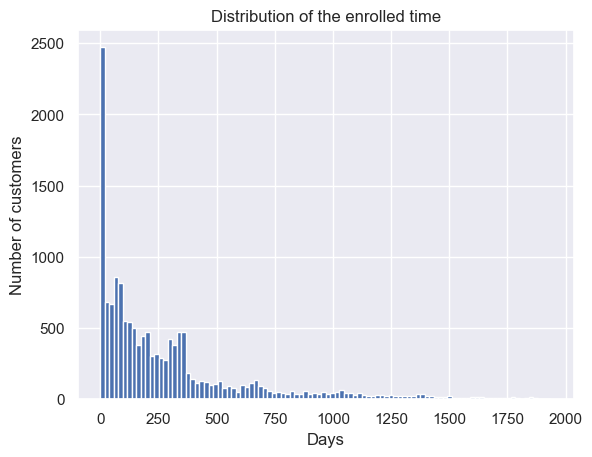

In [14]:
# plot the distribution of the enrolled time
data['EnrolledTime'].hist(bins=100)
plt.xlabel('Days')
plt.ylabel('Number of customers')
plt.title('Distribution of the enrolled time')
plt.show()

In [15]:
# 25% of people have enrolled for 0 days, which means they have enrolled and finished on the same day, let's investigate if they have dropped out or not

In [16]:
# check distribution of dropout for people that have enrolltime=0
data[data['EnrolledTime'] == 0]['Dropout'].value_counts()

Dropout
0    2422
Name: count, dtype: int64

In [17]:
# noone of these 25% has dropped out ? That means they should still be enrolled meaning there EnrollmentFinish should be 31.10.2019
# before fixing it we will check if these people came to the facility again after their EnrollmentFinish, meaning if DateLastVisit is after EnrollmentFinish

# show me the people that have enrolltime=0 and DateLastVisit after EnrollmentFinish
data[(data['EnrolledTime'] == 0) & (data['DateLastVisit'] > data['EnrollmentFinish'])].shape[0]


2422

In [18]:
# change the date of EnrollmentFinish for these people to 2019-10-31
data.loc[(data['EnrolledTime'] == 0) & (data['DateLastVisit'] > data['EnrollmentFinish']), 'EnrollmentFinish'] = '2019-10-31'
data['EnrollmentFinish'] = pd.to_datetime(data['EnrollmentFinish'])


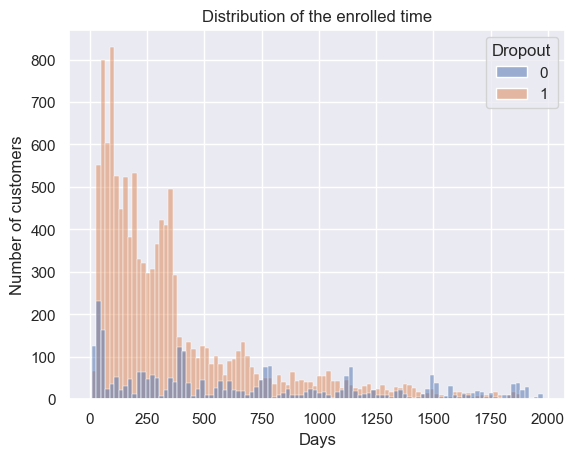

In [19]:
# recalculate the EnrolledTime
data['EnrolledTime'] = data['EnrollmentFinish'] - data['EnrollmentStart']
data['EnrolledTime'] = data['EnrolledTime'].dt.days

# plot the distribution of the enrolled time again and indicate with hue the dropout
sns.histplot(data=data, x='EnrolledTime', hue='Dropout', bins=100)
plt.xlabel('Days')
plt.ylabel('Number of customers')
plt.title('Distribution of the enrolled time')
plt.show()

In [20]:
# the reoccuring pattern has to do with the distrbution of months in enrollmentstart and finish. 
# let's drop the EnrollmentStart and EnrollmentFinish columns and keep only the EnrolledTime
data.drop(['EnrollmentStart', 'EnrollmentFinish'], axis=1, inplace=True)

## LastPeriodStartFinish

In [21]:
data['LastPeriodStart'] = pd.to_datetime(data['LastPeriodStart'])
data['LastPeriodFinish'] = pd.to_datetime(data['LastPeriodFinish'])

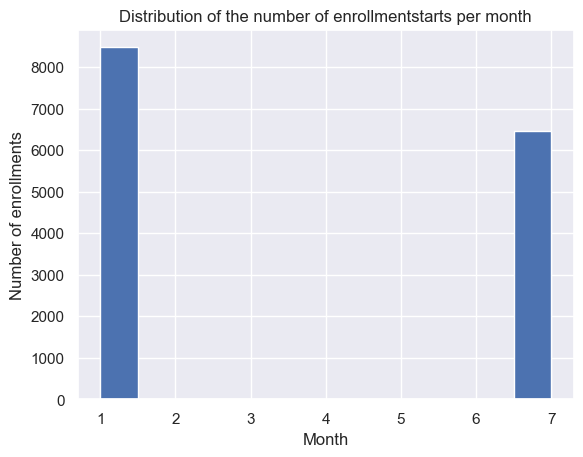

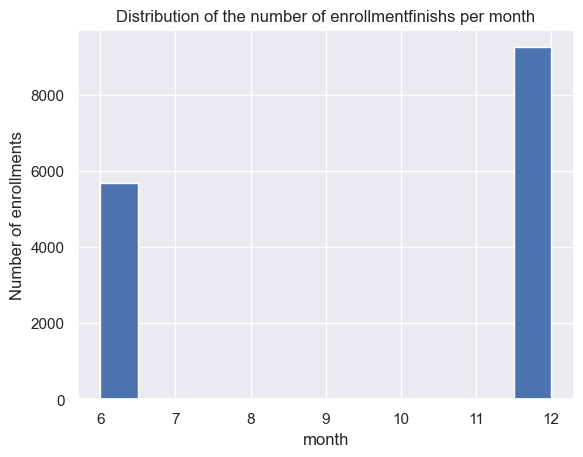

In [22]:
# distribution of LastPeriodStart per month
data['LastPeriodStart'].dt.month.hist(bins=12)
plt.xlabel('Month')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollmentstarts per month')
plt.show()

# distribution of LastPeriodFinish per month
data['LastPeriodFinish'].dt.month.hist(bins=12)
plt.xlabel('month')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollmentfinishs per month')
plt.show()

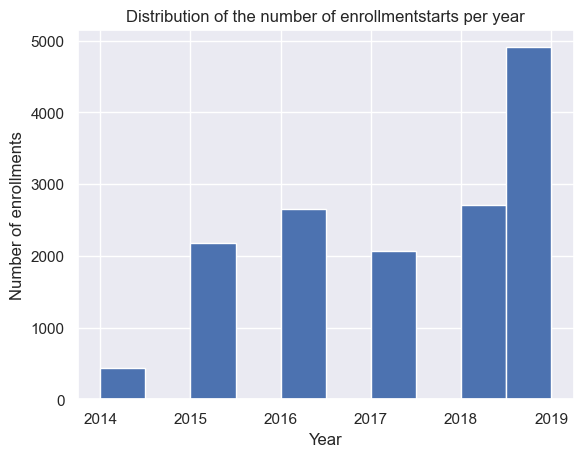

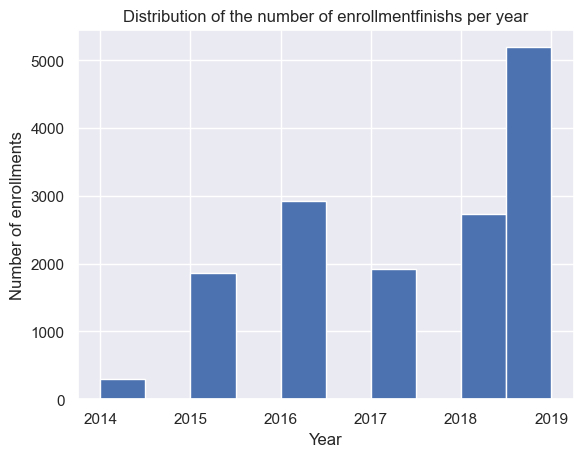

In [23]:
# is this giving us any insights ? Doesn't seem like it. Let's check the distribution of the LastPeriodStart and LastPeriodFinish per year
data['LastPeriodStart'].dt.year.hist(bins=10)
plt.xlabel('Year')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollmentstarts per year')
plt.show()

data['LastPeriodFinish'].dt.year.hist(bins=10)
plt.xlabel('Year')
plt.ylabel('Number of enrollments')
plt.title('Distribution of the number of enrollmentfinishs per year')
plt.show()

In [24]:
# the high value of 2019 is due to the reason we discussed earlier in enrolledtime. We will add this to the features_to_delete list
# drop the columns
data.drop(['LastPeriodStart', 'LastPeriodFinish'], axis=1, inplace=True)

## DateLastVisit

In [25]:
# create a column days_since_last_visit
data['DateLastVisit'] = pd.to_datetime(data['DateLastVisit'])
data['DaysSinceLastVisit'] = (pd.to_datetime('2019-10-31') - data['DateLastVisit']).dt.days

In [26]:
data.drop('DateLastVisit', axis=1, inplace=True)

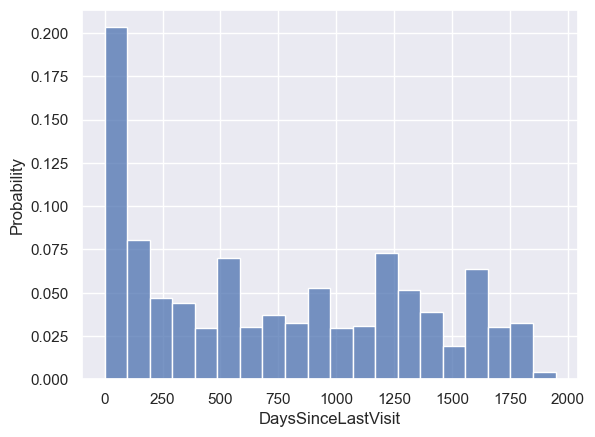

In [27]:
# plot distribution of DaysSinceLastVisit
sns.histplot(data=data, x='DaysSinceLastVisit', bins=20, stat='probability')
plt.show()

In [28]:
# seems as if a lot of people came very recently (today ~ last day of observation) to the facility

## AllowedWeeklyVisitsBySLA

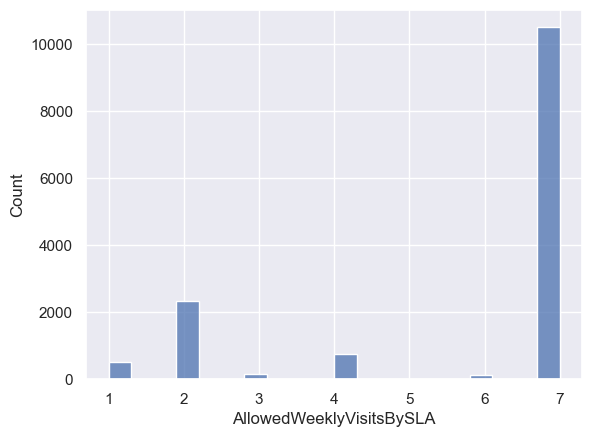

In [29]:
# plot distribution of AllowedWeeklyVisitsBySLA column
sns.histplot(data=data, x='AllowedWeeklyVisitsBySLA', bins=20)
plt.show()



In [30]:
# fill nans with mode for now
data['AllowedWeeklyVisitsBySLA'].fillna(data['AllowedWeeklyVisitsBySLA'].mode()[0], inplace=True)

## AllowedNumberOfVisitsBySLA

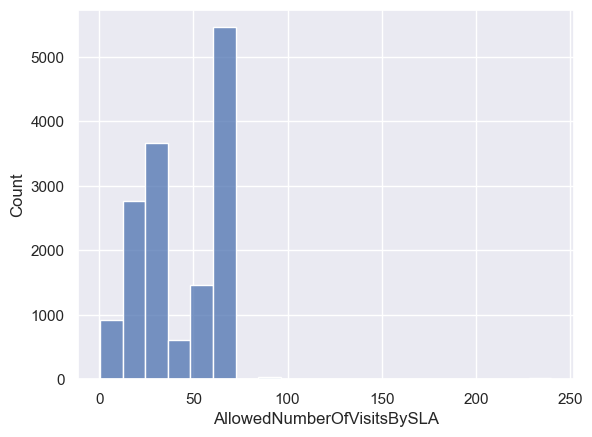

In [31]:
# give me distribution of AllowedNumberOfVisitsBySLA
sns.histplot(data=data, x='AllowedNumberOfVisitsBySLA', bins=20)
plt.show()

## RealNumberOfVisits

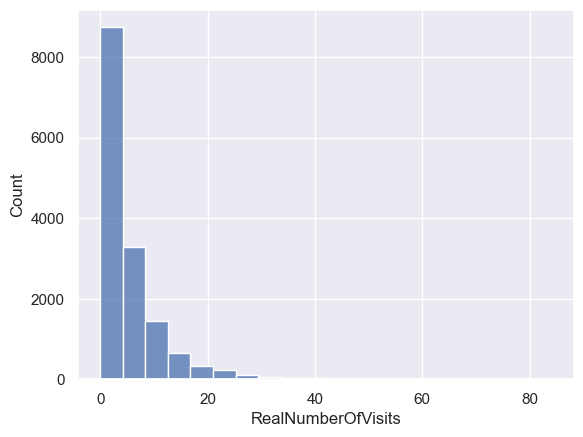

In [32]:
# distribution realnumberofvisits
sns.histplot(data=data, x='RealNumberOfVisits', bins=20)
plt.show()

In [33]:
# create a column that shows the difference between the allowed and real number of visits
data['LazinessIndex'] = 1 - data['RealNumberOfVisits'] / data['AllowedNumberOfVisitsBySLA']

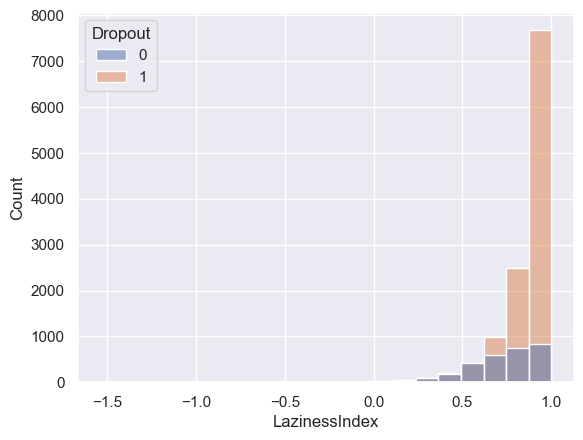

In [34]:
# laziness index by dropout
sns.histplot(data=data, x='LazinessIndex', hue='Dropout', bins=20)
plt.show()


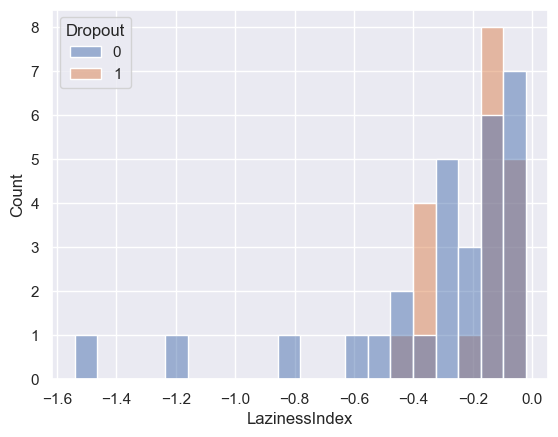

In [35]:
sns.histplot(data=data[data['LazinessIndex'] < 0], x='LazinessIndex', hue='Dropout', bins=20)
plt.show()

In [36]:
# the laziness index is a good indicator of dropout. The higher the laziness index the more likely the customer is to drop out

In [37]:
# we will drop the AllowedWeeklyVisitsBySLA, AllowedNumberOfVisitsBySLA, RealNumberOfVisits columns
data.drop(['AllowedWeeklyVisitsBySLA', 'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits'], axis=1, inplace=True)

## NumberOfRenewals

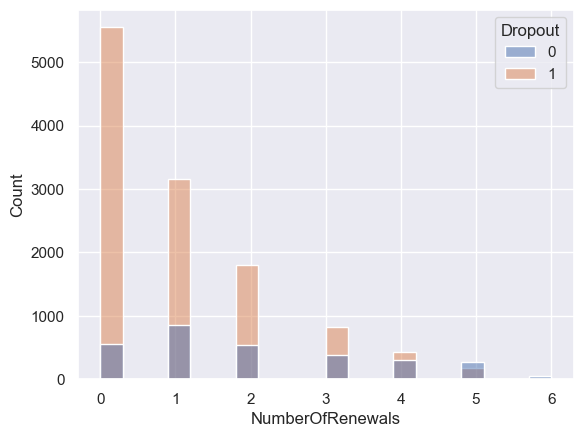

In [38]:
# distribution of NumerOfRenewals with hue dropout
sns.histplot(data=data, x='NumberOfRenewals', hue='Dropout', bins=20)
plt.show()

In [39]:
# again a good indicator of dropout. The higher the number of renewals the more likely the customer is to drop out or is it the other way around ?

In [40]:
# # create column number_of_renewals per enrolled time
# data['NumberOfRenewalsPerEnrolledTime'] = data['NumberOfRenewals'] / data['EnrolledTime']

# # plot the distribution of the number of renewals per enrolled time
# sns.histplot(data=data, x='NumberOfRenewalsPerEnrolledTime', hue='Dropout', bins=20)
# plt.show()

## NumberOfReferences

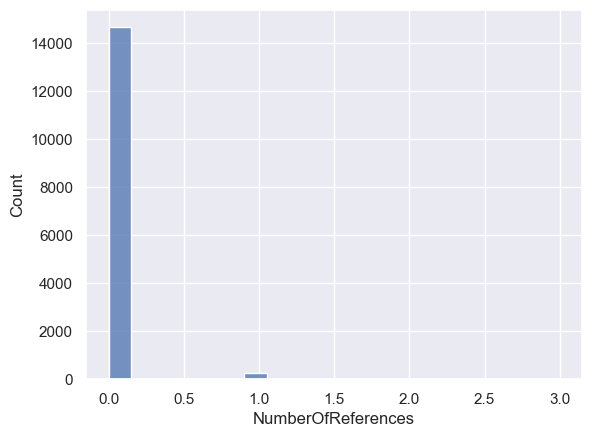

NumberOfReferences
0    14646
1      267
2       21
3        8
Name: count, dtype: int64

In [41]:
# plot distribution of NumberOfReferences
sns.histplot(data=data, x='NumberOfReferences', bins=20)
plt.show()

# value counts of NumberOfReferences
data['NumberOfReferences'].value_counts()


## AttendedClasses

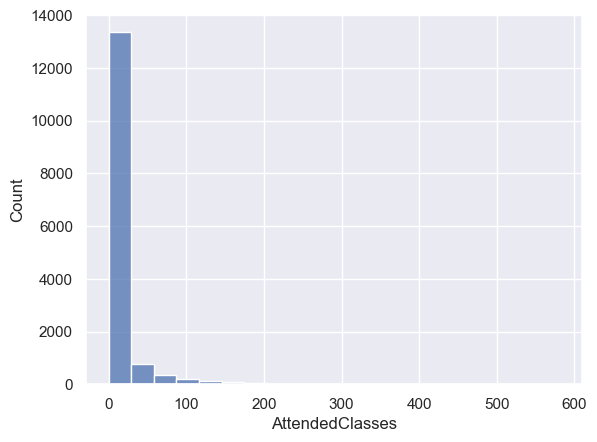

In [42]:
# distribution of AttendedClasses
sns.histplot(data=data, x='AttendedClasses', bins=20)
plt.show()

## Age

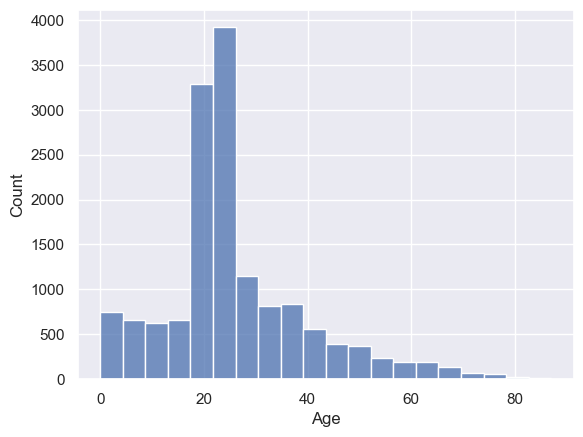

In [43]:
# distribution of Age
sns.histplot(data=data, x='Age', bins=20)
plt.show()

## Income

In [44]:
# fill missing values in income with median of age group
data['Income'].fillna(data.groupby('Age')['Income'].transform('median'), inplace=True)

## Gender

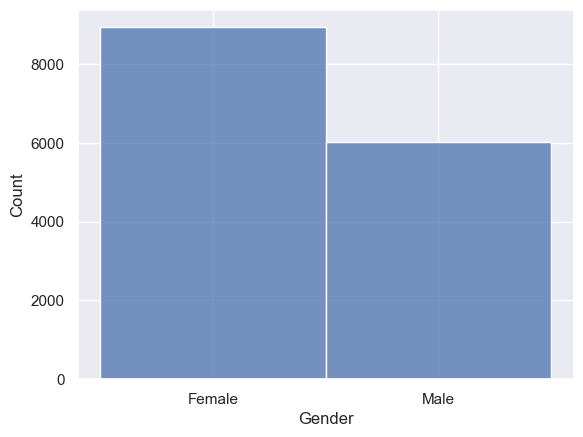

In [45]:
# distribution of gender
sns.histplot(data=data, x='Gender', bins=20)
plt.show()

In [46]:
# map male to 1 and female to 0
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})

## UseByTime

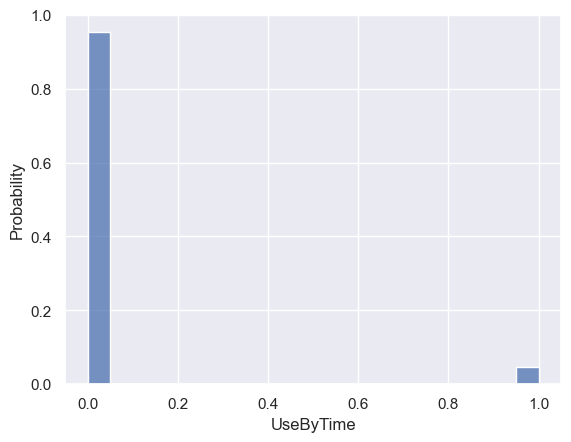

In [47]:
# show the same plot but the percentage of the total
sns.histplot(data=data, x='UseByTime', bins=20, stat='probability')
plt.show()

In [48]:
# keep for now but might drop later with variance threshold

## LifeTimeValue

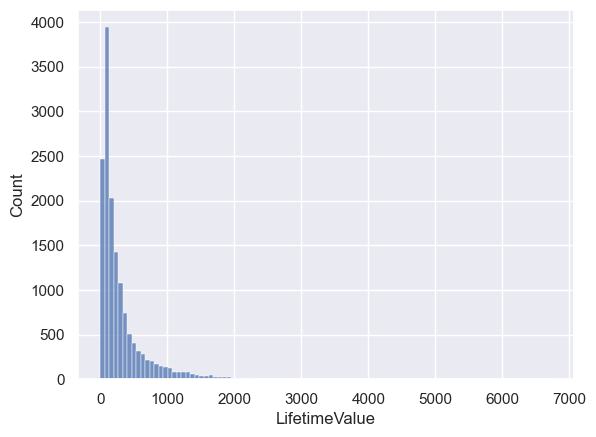

In [49]:
# distribution of LifetimeValue
sns.histplot(data=data, x='LifetimeValue', bins=100)
plt.show()

## Activities

In [50]:
activity_types = ["AthleticsActivities", "WaterActivities", "FitnessActivities",
                  "DanceActivities", "TeamActivities", "RacketActivities",
                  "CombatActivities", "NatureActivities", "SpecialActivities",
                  "OtherActivities"]

# Calculate the total number of records for the denominator
total_customers = len(data)

print("Percentage of customers who have participated in each activity type:")
# Calculate and print percentages for each activity type
for activity in activity_types:
    percentage = (data[activity] == 1.0).sum() / total_customers * 100
    print(f"{activity}: {percentage:.2f}%")

Percentage of customers who have participated in each activity type:
AthleticsActivities: 0.74%
WaterActivities: 29.55%
FitnessActivities: 57.47%
DanceActivities: 0.00%
TeamActivities: 5.54%
RacketActivities: 2.34%
CombatActivities: 10.77%
NatureActivities: 0.00%
SpecialActivities: 2.64%
OtherActivities: 0.19%


In [51]:
# fill all activity types with each mode
for activity in activity_types:
    data[activity].fillna(data[activity].mode()[0], inplace=True)

In [52]:
# drop the ones with 100% of no participation?
# or not ? this is already an insight
data = data.drop(["DanceActivities","NatureActivities"], axis=1)

## NumberOfFrequencies

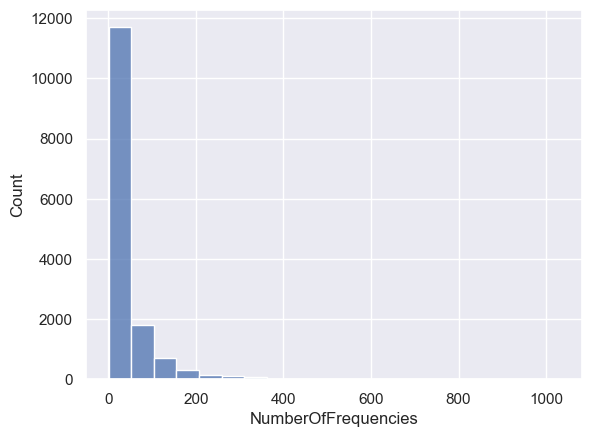

In [53]:
# plot distribution of NumberOfFrequencies column
sns.histplot(data=data, x='NumberOfFrequencies', bins=20)
plt.show()

In [54]:
# median of NumberOfFrequencies with mode
data['NumberOfFrequencies'].fillna(data['NumberOfFrequencies'].mode()[0], inplace=True)

## DaysWithoutFrequency

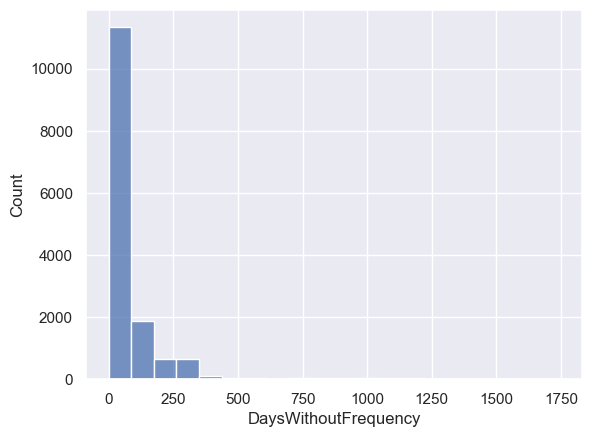

In [55]:
# plot distribution of DaysWithoutFrequency column
sns.histplot(data=data, x='DaysWithoutFrequency', bins=20)
plt.show()

In [56]:
# correlation of DaysWithoutFrequency with DaysSinceLastVisit
data[['DaysWithoutFrequency', 'DaysSinceLastVisit']].corr()

,DaysWithoutFrequency,DaysSinceLastVisit
DaysWithoutFrequency,1.00000,0.34759
DaysSinceLastVisit,0.34759,1.00000


In [57]:
# now the same correlation but only for the ones that are not dropped out
data[data['Dropout'] == 0][['DaysWithoutFrequency', 'DaysSinceLastVisit']].corr()

,DaysWithoutFrequency,DaysSinceLastVisit
DaysWithoutFrequency,1.0,1.0
DaysSinceLastVisit,1.0,1.0


In [58]:
# can we drop based on that ? 

## HasReferences

In [59]:
data['HasReferences'] = data['HasReferences'].replace({'yes': 1, 'no': 0})

data[['HasReferences', 'NumberOfReferences']].corr()

,HasReferences,NumberOfReferences
HasReferences,1.000000,0.918348
NumberOfReferences,0.918348,1.000000


In [60]:
# we can drop has references
data = data.drop(["HasReferences"], axis=1)

## NumberOfReferences

In [61]:
# distribution of NumberOfReferences in values
data['NumberOfReferences'].value_counts(normalize=True)

NumberOfReferences
0    0.980190
1    0.017869
2    0.001405
3    0.000535
Name: proportion, dtype: float64

# Variance

In [62]:
# let's check the variance of the features
data.var()

Age                     2.004088e+02
Gender                  2.404686e-01
Income                  2.504466e+06
DaysWithoutFrequency    2.079352e+04
LifetimeValue           1.327287e+05
UseByTime               4.489865e-02
AthleticsActivities     7.308092e-03
WaterActivities         2.081838e-01
FitnessActivities       2.440825e-01
TeamActivities          5.234703e-02
RacketActivities        2.281296e-02
CombatActivities        9.609383e-02
SpecialActivities       2.573844e-02
OtherActivities         1.870526e-03
NumberOfFrequencies     4.280924e+03
AttendedClasses         8.499675e+02
NumberOfRenewals        1.908003e+00
NumberOfReferences      2.781465e-02
Dropout                 1.594315e-01
EnrolledTime            1.867487e+05
DaysSinceLastVisit      3.494062e+05
LazinessIndex           3.268654e-02
dtype: float64

In [63]:
# drop automatically features with variance less than 0.01
features_to_delete_var = data.var()[data.var() < 0.01].index.tolist()
data.drop(features_to_delete_var, axis=1, inplace=True)


# Correlation

In [64]:
metric_features = ['EnrolledTime', 'DaysSinceLastVisit', 'LazinessIndex', 'NumberOfRenewals', 'NumberOfReferences', 'AttendedClasses', 'Age', 'Income', 'LifetimeValue', 'NumberOfFrequencies', 'DaysWithoutFrequency']

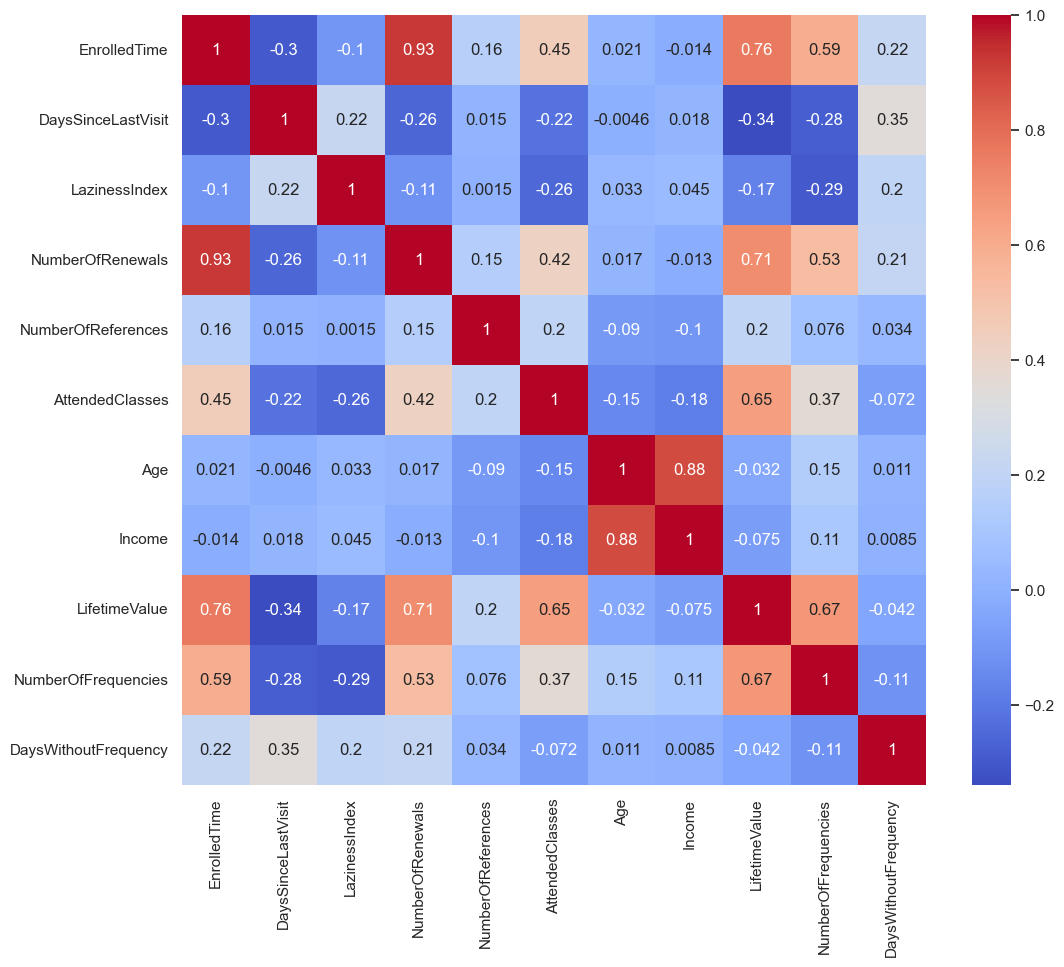

In [65]:
# give correlation matrix of metric features
data[metric_features].corr()

# plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data[metric_features].corr(), annot=True, cmap='coolwarm')
plt.show()

In [66]:
# drop features with a correlation higher than 0.8
features_to_delete_cor = ['Age', 'NumberOfRenewals']
data.drop(features_to_delete_cor, axis=1, inplace=True)

# lifetimevalue, numberofrenewals correlated with enrolledtime

In [67]:
# please check that and play with the features you want to drop here
# scaling you are doing later on by playing with the features you want to keep right ? Saw something like that in your notebook

In [68]:
data.columns

Index(['Gender', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'UseByTime', 'WaterActivities', 'FitnessActivities', 'TeamActivities',
       'RacketActivities', 'CombatActivities', 'SpecialActivities',
       'NumberOfFrequencies', 'AttendedClasses', 'NumberOfReferences',
       'Dropout', 'EnrolledTime', 'DaysSinceLastVisit', 'LazinessIndex'],
      dtype='object')

# Outliers

In [69]:
data.describe(include="all").T

# Features to analyse for outliers:

# - Income
# - DaysWithoutFrequency
# - LifetimeValue
# - NumberofFrequencies
# - AttendedClasses
# - EnrolledTime
# - LazinessIndex

,count,mean,std,min,25%,50%,75%,max
Gender,14942.0,0.402289,0.490376,0.000000,0.000000,0.0000,1.000000,1.0
Income,14942.0,2180.503279,1582.550391,0.000000,1420.000000,1970.0000,2760.000000,10890.0
DaysWithoutFrequency,14942.0,81.224936,144.199576,0.000000,13.000000,41.0000,83.750000,1745.0
LifetimeValue,14942.0,302.561871,364.319566,0.000000,83.600000,166.2000,355.075000,6727.8
UseByTime,14942.0,0.047116,0.211893,0.000000,0.000000,0.0000,0.000000,1.0
WaterActivities,14942.0,0.295476,0.456272,0.000000,0.000000,0.0000,1.000000,1.0
FitnessActivities,14942.0,0.577031,0.494047,0.000000,0.000000,1.0000,1.000000,1.0
TeamActivities,14942.0,0.055414,0.228795,0.000000,0.000000,0.0000,0.000000,1.0
RacketActivities,14942.0,0.023357,0.151040,0.000000,0.000000,0.0000,0.000000,1.0
CombatActivities,14942.0,0.107683,0.309990,0.000000,0.000000,0.0000,0.000000,1.0


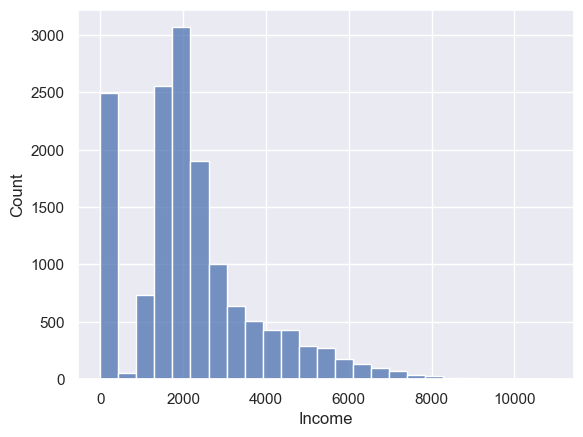

In [70]:
sns.histplot(data=data, x='Income', bins=25)
plt.show()

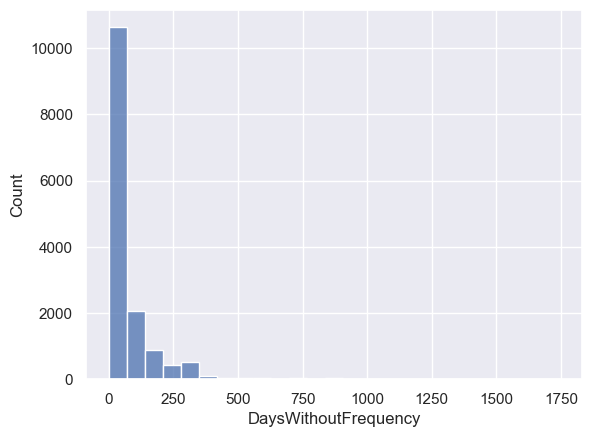

In [71]:
sns.histplot(data=data, x='DaysWithoutFrequency', bins=25)
plt.show()

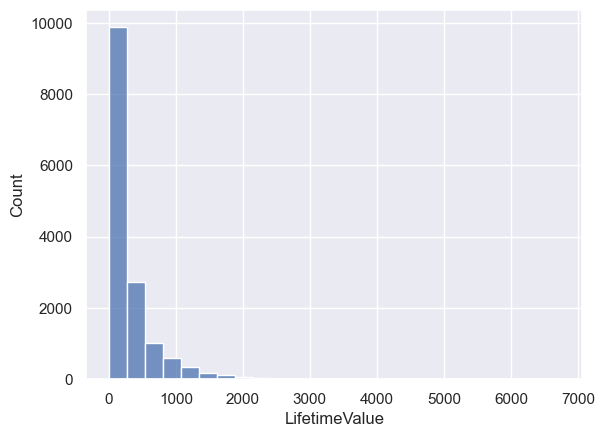

In [72]:
sns.histplot(data=data, x='LifetimeValue', bins=25)
plt.show()

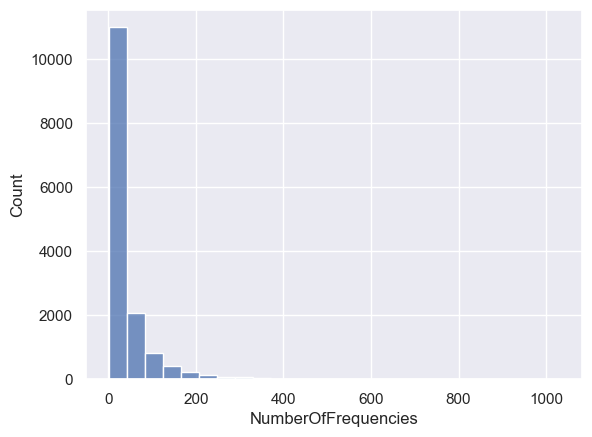

In [73]:
sns.histplot(data=data, x='NumberOfFrequencies', bins=25)
plt.show()

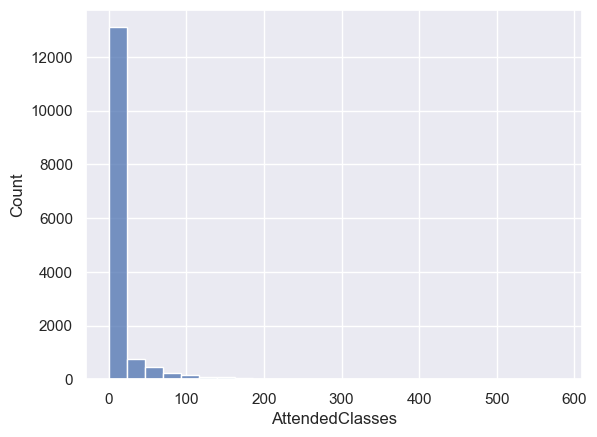

In [74]:
sns.histplot(data=data, x='AttendedClasses', bins=25)
plt.show()

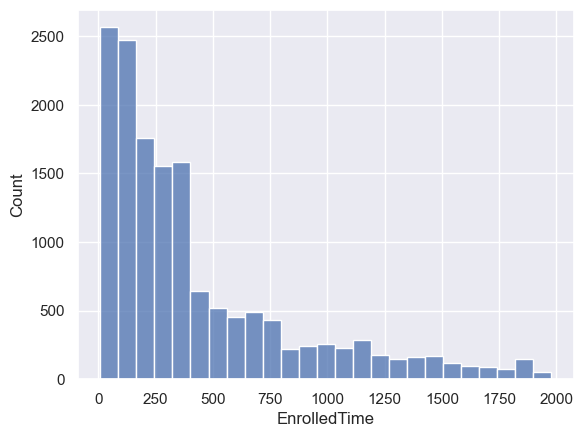

In [75]:
sns.histplot(data=data, x='EnrolledTime', bins=25)
plt.show()

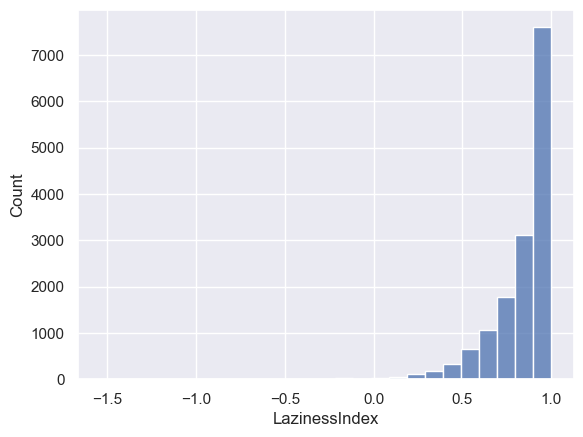

In [76]:
sns.histplot(data=data, x='LazinessIndex', bins=25)
plt.show()

## Deleting Outliers

In [77]:
# INTERQUARTILE APPROACH #

features_chosen = ["Income","DaysWithoutFrequency","LifetimeValue","NumberOfFrequencies","AttendedClasses",
                  "EnrolledTime","LazinessIndex"]

q25 = data[features_chosen].quantile(.25)
q75 = data[features_chosen].quantile(.75)
iqr = q75 - q25

# get limits for outliers
upper_lim = q75 + 1.5*iqr
lower_lim = q25 - 1.5*iqr

filters = []
for feature in features_chosen:
    llim = lower_lim[feature]
    ulim = upper_lim[feature]
    filters.append(data[feature].between(llim, ulim, inclusive='both'))

filters = np.all(filters, 0)
data_clean = data[filters]

print('Percentage of data kept after removing outliers:', np.round(data_clean.shape[0] / data.shape[0], 4))

Percentage of data kept after removing outliers: 0.5746


In [78]:
# Way too much data removed. Going for the 'by hand' approach:

In [79]:
data_byhand = data.copy()

filters_byhand = (
    (data_byhand["Income"] < 9000)         
    & (data_byhand["DaysWithoutFrequency"] < 400)
    & (data_byhand["LifetimeValue"] < 2600)
    & (data_byhand["NumberOfFrequencies"] < 380)
    & (data_byhand["AttendedClasses"] < 190)
    & (data_byhand["EnrolledTime"] < 1850)
    & (data_byhand["LazinessIndex"] > -0.7)
)

data_byhand = data[filters_byhand]

print('Percentage of data kept after removing outliers:', np.round(data_byhand.shape[0] / data.shape[0], 4))

Percentage of data kept after removing outliers: 0.9588


In [80]:
# Now we can merge the two methods together: (remove only the ones considered outliers for both)

In [81]:
data_new = data[(filters | filters_byhand)]       

print('Percentage of data kept after removing outliers:', np.round(data_new.shape[0] / data.shape[0], 4))

Percentage of data kept after removing outliers: 0.9588


# Save data for clustering

In [82]:
data_new.head()

,Gender,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,NumberOfFrequencies,AttendedClasses,NumberOfReferences,Dropout,EnrolledTime,DaysSinceLastVisit,LazinessIndex
ID,,,,,,,,,,,,,,,,,,
0,0,5500.0,1,89.35,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,7,0,0,58,1,0.681529
1,0,2630.0,60,479.20,0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,1,0,1,398,1568,0.942595
2,1,1980.0,7,37.60,0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0,0,1,30,889,0.800200
3,1,0.0,22,155.40,0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,2,0,1,160,283,0.830700
4,1,4320.0,210,373.20,0,0.0,1.0,0.0,0.0,0.0,0.0,41.0,0,0,1,778,721,1.000000


In [83]:
data_new.to_csv('cleaned_data.csv', index=False)

# Continues in 'Clustering.ipynb'